# Credit score classification project

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split
import seaborn as sns

# Train test split
First of all we need to split our data into train, validation and test sets.

Even though there is a test set given in the competition files, we don't have any access to the target variables, so we decided to use train.csv file only

In [124]:
data = pd.read_csv('train.csv') # dataframe containg everything, not only train
# test = pd.read_csv('test.csv') this one doesn't works - missing target value

test_size = 0.2
X = data.drop(columns=["Credit_Score"]).copy()
y = data["Credit_Score"] # the target 


X_rem, X_test, y_rem, y_test = train_test_split(X,y, test_size=test_size, shuffle=False) 
X_train, X_val, y_train, y_val = train_test_split(X_rem, y_rem, test_size=test_size, shuffle=False) 
#X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=test_size, shuffle=False)

Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.


In [125]:
# merged in order to perfrom preprocessing efficiently
train = X_train.join(y_train)
val = X_val.join(y_val)

# Data Examination

Let's have a look into our data

In [5]:
train.head(5)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 0 to 63999
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        64000 non-null  object 
 1   Customer_ID               64000 non-null  object 
 2   Month                     64000 non-null  object 
 3   Name                      57607 non-null  object 
 4   Age                       64000 non-null  object 
 5   SSN                       64000 non-null  object 
 6   Occupation                64000 non-null  object 
 7   Annual_Income             64000 non-null  object 
 8   Monthly_Inhand_Salary     54425 non-null  float64
 9   Num_Bank_Accounts         64000 non-null  int64  
 10  Num_Credit_Card           64000 non-null  int64  
 11  Interest_Rate             64000 non-null  int64  
 12  Num_of_Loan               64000 non-null  object 
 13  Type_of_Loan              56824 non-null  object 
 14  Delay_

In [7]:
train["Customer_ID"].value_counts().loc[train["Customer_ID"].value_counts() != 8].size 
# every customer shows up exactly 8 times

0

In [8]:
train['Credit_Score'].isna().sum() # all target values are present

0

(array([11469.,     0.,     0.,     0.,     0., 33817.,     0.,     0.,
            0., 18714.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

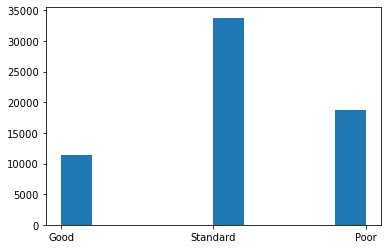

In [9]:
plt.hist(train["Credit_Score"]) # target distribution

In [10]:
train[["Name", "SSN", "Customer_ID"]].head(10) # name, customer id and SSN are redundant

,Name,SSN,Customer_ID
0,Aaron Maashoh,821-00-0265,CUS_0xd40
1,Aaron Maashoh,821-00-0265,CUS_0xd40
2,Aaron Maashoh,821-00-0265,CUS_0xd40
3,Aaron Maashoh,821-00-0265,CUS_0xd40
4,Aaron Maashoh,821-00-0265,CUS_0xd40
5,Aaron Maashoh,821-00-0265,CUS_0xd40
6,Aaron Maashoh,821-00-0265,CUS_0xd40
7,NaN,#F%$D@*&8,CUS_0xd40
8,Rick Rothackerj,004-07-5839,CUS_0x21b1
9,Rick Rothackerj,004-07-5839,CUS_0x21b1


In [11]:
columns_to_alter = ['Age', 'Annual_Income', 'Num_of_Loan','Num_of_Delayed_Payment',
                    'Changed_Credit_Limit', 'Outstanding_Debt',
                    'Amount_invested_monthly', 'Monthly_Balance']

train[columns_to_alter].iloc[10:20] # some columns have weird signs - "_" and are of wrong format

,Age,Annual_Income,Num_of_Loan,Num_of_Delayed_Payment,Changed_Credit_Limit,Outstanding_Debt,Amount_invested_monthly,Monthly_Balance
10,28,34847.84_,1,-1,5.42,605.03,58.51597569589465,466.46647639764313
11,28,34847.84,1,3_,5.42,605.03,99.30622796053305,465.6762241330048
12,28,34847.84,1,1,6.42,605.03,130.11542024292334,444.8670318506144
13,28,34847.84,1,0,5.42,605.03,43.477190144355745,481.505261949182
14,28,34847.84,1,4,5.42,605.03,70.10177420755677,464.8806778859809
15,28,34847.84,1,4,5.42,605.03,218.90434353388733,356.07810855965045
16,34,143162.64,3,8,7.1,1303.01,168.413702679309,1043.3159778669492
17,34,143162.64,3,6,7.1,1303.01,232.86038375993544,998.8692967863226
18,34,143162.64,3,7,11.1,1303.01,__10000__,715.741367403555
19,34,143162.64,3,5,9.1,1303.01,825.2162699393922,426.5134106068658


In [12]:
# how different are categorical columns

print(train['Payment_of_Min_Amount'].unique(), "\n\n",
      train['Occupation'].unique(), "\n\n",
      train["Credit_Mix"].unique(), "\n\n",
      train["Payment_Behaviour"].unique())

['No' 'NM' 'Yes'] 

 ['Scientist' '_______' 'Teacher' 'Engineer' 'Entrepreneur' 'Developer'
 'Lawyer' 'Media_Manager' 'Doctor' 'Journalist' 'Manager' 'Accountant'
 'Musician' 'Mechanic' 'Writer' 'Architect'] 

 ['_' 'Good' 'Standard' 'Bad'] 

 ['High_spent_Small_value_payments' 'Low_spent_Large_value_payments'
 'Low_spent_Medium_value_payments' 'Low_spent_Small_value_payments'
 'High_spent_Medium_value_payments' '!@9#%8'
 'High_spent_Large_value_payments']


In [13]:
# account age, and behaviour are in unfriendly format

train[["Credit_History_Age", "Payment_Behaviour"]].head()

,Credit_History_Age,Payment_Behaviour
0,22 Years and 1 Months,High_spent_Small_value_payments
1,NaN,Low_spent_Large_value_payments
2,22 Years and 3 Months,Low_spent_Medium_value_payments
3,22 Years and 4 Months,Low_spent_Small_value_payments
4,22 Years and 5 Months,High_spent_Medium_value_payments


<AxesSubplot:>

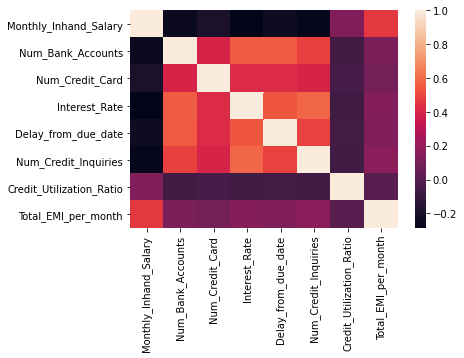

In [14]:
sns.heatmap(train.corr(method="spearman"))

## Search for outliers

In [15]:
description = train.describe()

print(description)

       Monthly_Inhand_Salary  Num_Bank_Accounts  Num_Credit_Card  \
count           54425.000000       64000.000000     64000.000000   
mean             4200.666742          17.011688        22.776141   
std              3195.453352         117.426876       130.332827   
min               319.556250          -1.000000         0.000000   
25%              1628.297500           3.000000         4.000000   
50%              3081.902500           6.000000         6.000000   
75%              5967.333333           7.000000         7.000000   
max             15204.633333        1798.000000      1499.000000   

       Interest_Rate  Delay_from_due_date  Num_Credit_Inquiries  \
count   64000.000000         64000.000000          62794.000000   
mean       70.978344            21.120750             27.466223   
std       459.881448            14.823882            190.055037   
min         1.000000            -5.000000              0.000000   
25%         8.000000            10.000000           

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'Customer_ID'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Name'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'SSN'}>,
        <AxesSubplot:title={'center':'Occupation'}>,
        <AxesSubplot:title={'center':'Annual_Income'}>,
        <AxesSubplot:title={'center':'Monthly_Inhand_Salary'}>,
        <AxesSubplot:title={'center':'Num_Bank_Accounts'}>],
       [<AxesSubplot:title={'center':'Num_Credit_Card'}>,
        <AxesSubplot:title={'center':'Interest_Rate'}>,
        <AxesSubplot:title={'center':'Num_of_Loan'}>,
        <AxesSubplot:title={'center':'Type_of_Loan'}>,
        <AxesSubplot:title={'center':'Delay_from_due_date'}>],
       [<AxesSubplot:title={'center':'Num_of_Delayed_Payment'}>,
        <AxesSubplot:title={'center':'Changed_Credit_Limit'}>,
        <AxesSubplot:title={'center':'Num_Credit_Inquiries'}>,
  

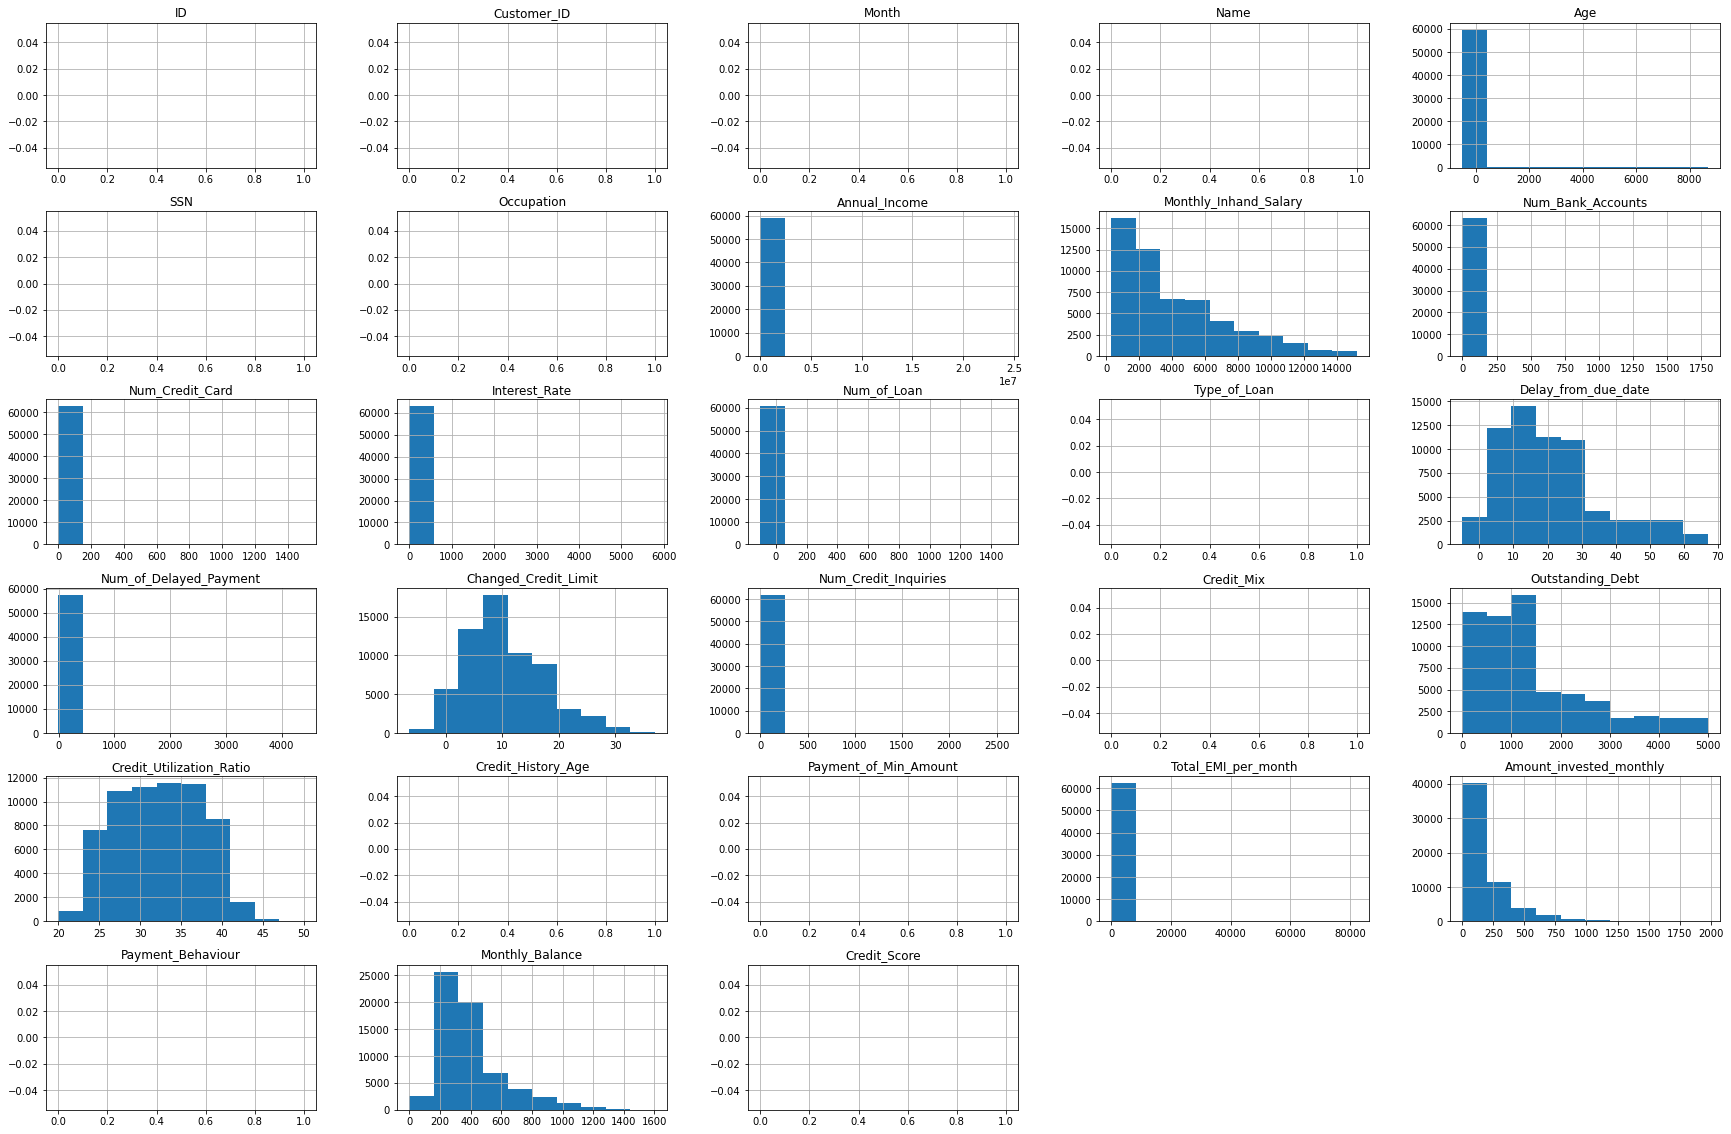

In [16]:
df = train.copy()
for col in train.columns:
    df[col] = pd.to_numeric(train[col], errors='coerce') # errors='coerce', then invalid parsing will be set as NaN

# distribution of all the variables
df.hist(figsize=(30, 20))

some of the plots look very weirdly - they consists of only one column. It probably means that those features contain some outliers.

In [17]:
# we choose outliers by looking at the plots

columns_with_outliers = ["Age", "Annual_Income", "Num_Bank_Accounts", 
                         "Num_Credit_Card", "Interest_Rate", 
                         "Num_of_Loan", "Num_of_Delayed_Payment",
                         "Num_Credit_Inquiries", "Total_EMI_per_month"]


df[columns_with_outliers].quantile(0.98)

Age                           56.00
Annual_Income             166891.60
Num_Bank_Accounts             10.00
Num_Credit_Card              187.02
Interest_Rate                 60.08
Num_of_Loan                    9.00
Num_of_Delayed_Payment        25.00
Num_Credit_Inquiries          17.00
Total_EMI_per_month        29527.08
Name: 0.98, dtype: float64

<AxesSubplot:>

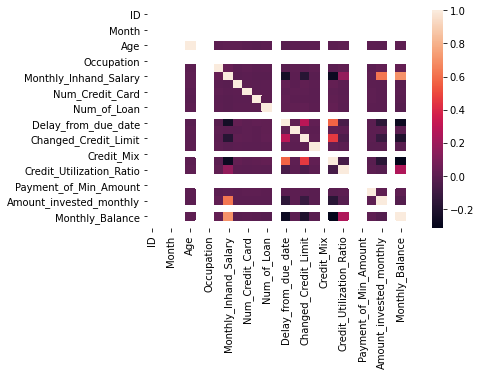

In [18]:
# correlation between columns 
sns.heatmap(df.corr())

<BarContainer object of 3 artists>

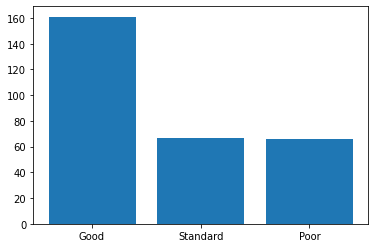

In [19]:
# Monthly_Inhand_Salary is strongly correlated with Monthly_Balance and 
# Amount_Invested_Monthly but those are not correlated with each other

plt.bar(x = train["Credit_Score"].unique(),
        height=train.loc[df["Num_of_Loan"]>=15]["Credit_Score"].value_counts())

# Data Preprocessing

In [20]:
def id_columns(df):
    df = df.drop(["Name", "SSN", "ID"], axis="columns") # no added value, all the information in Customer_ID
    df["Customer_ID"] = df["Customer_ID"].apply(lambda x: int(x[4:], 16)) # convert to int
    
    print("Columns containing id-like information preprocessed")
    return df

In [21]:
def clear_numeric_data(col):
    # some of the rows contain "_" sign
    col.astype(str).replace("_", "")
    return pd.to_numeric(col, errors="coerce") # errors='coerce', then invalid parsing will be set as NaN

In [22]:
# function for cleaning numeric data where necessary
def altering(df):
    
    columns_to_alter = ['Age', 'Annual_Income', 'Num_of_Loan','Num_of_Delayed_Payment',
                        'Changed_Credit_Limit', 'Outstanding_Debt',
                        'Amount_invested_monthly', 'Monthly_Balance']

    df[columns_to_alter] = df[columns_to_alter].apply(clear_numeric_data, axis=1)

    print("Numeric data preprocessed. Columns with numeric values contain numeric only variables. Changed columns types")
    return df

In [23]:
def delete_outliers(column, a=0, b=0.98, use_quantiles=True):
    # function helps removing quantiles from a column, 
    # if parameter (use_quantiles) is False, removes outliers outside given range (a, b)
    # otherwise removes top quantiles
    
    col = np.where(a < column, column, float('nan'))
    if use_quantiles:
        return np.where(col <= column.quantile(b), column, float('nan'))
    return np.where(col <= b, column, float('nan'))


def handle_outliers(df):
    df["Age"] = np.where((0 > df["Age"]), -df["Age"], df["Age"]) # deleting weird outliers
    df['Age'] = delete_outliers(df["Age"], 0, 100, use_quantiles=False)
    
    df["Annual_Income"] = delete_outliers(df["Annual_Income"])
    df["Num_Bank_Accounts"] = delete_outliers(df["Num_Bank_Accounts"])
    df["Num_of_Loan"] = delete_outliers(df["Num_of_Loan"])
    df["Interest_Rate"] = delete_outliers(df["Interest_Rate"])
    df["Num_Credit_Card"] = delete_outliers(df["Num_Credit_Card"], 0, 0.97)
    df["Num_of_Delayed_Payment"] = delete_outliers(df["Num_of_Delayed_Payment"])
    df["Num_Credit_Inquiries"] = delete_outliers(df["Num_Credit_Inquiries"])
    df["Total_EMI_per_month"] = delete_outliers(df["Total_EMI_per_month"], 0, 0.95)


    print("Deleted outliers")   
    
    return df

## Encoding categorical data

In [24]:
train["Occupation"] = np.where(train["Occupation"] == "_______", "Unknown", train["Occupation"])
occupations_list = train["Occupation"].unique()
occupations_list

array(['Scientist', 'Unknown', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

In [25]:
# first we fill the information for customers that have other rows with full information available
train['Type_of_Loan'].fillna(train.groupby('Customer_ID')['Type_of_Loan'].first(), inplace=True)
# later we fill with ''
train['Type_of_Loan'].fillna('', inplace=True)
    
loan_types_list =  train['Type_of_Loan'].value_counts().head(9).index[1:] 

In [118]:
def encode_categorical(df):
    # encode columns where necessary (Credit_Mix, Payment_of_Min_Amount, Credit_Score)
    # mapping
    credit_mix_dict = {'Bad':0, 'Standard':1, 'Good':2, '_':float('nan')}
    poma_dict = {'No':0, 'Yes':1, 'NM':float('nan')}
    credit_score_dict = {'Poor':0, 'Standard':1, 'Good':2}
    month_dict = {"January": 1, "February": 2, "March": 3, "April": 4, "May": 5,
                "June": 6, "July": 7, "August": 8}
    
    
    df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map(poma_dict)
    df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_dict)
    df['Credit_Score'] = df['Credit_Score'].map(credit_score_dict)
    df["Month"] = df["Month"].map(month_dict)
    
    # Payment_Behaviour column brings two informations, one about spending, other about value payments
    df["Payment_Behaviour"] = df["Payment_Behaviour"].replace('!@9#%8', 'Unknown_spent_Unknown_value_payments')
    split_payment = lambda x:  ([x.split("_")[0], x.split("_")[2]] if (x is not None) else ["Unknown", "Unknown"])
    df["Payment_Behaviour"] = df["Payment_Behaviour"].apply(split_payment)
    
    df[["Spending_Behaviour", "Value_Payments"]] = pd.DataFrame(df["Payment_Behaviour"].tolist(), index=df.index)
    
    spending_dict = {'Low':0, 'High':1, 'Unknown':float('nan')}
    value_dict = {'Small':0, 'Medium':1, 'Large':2,  'Unknown':float('nan')}
    
    df['Spending_Behaviour'] = df['Spending_Behaviour'].map(spending_dict)
    df['Value_Payments'] = df['Value_Payments'].map(value_dict)
    
    
    del df["Payment_Behaviour"]
    
    
    for loan_type in loan_types_list: # the single types of loans
        df[loan_type] = df['Type_of_Loan'].str.contains(loan_type).astype("bool")
    del df["Type_of_Loan"]
    
    
    # credit history age    
    df['Credit_History_Age'] = df['Credit_History_Age'].apply(history_age)
    
    # Occupation - ____ for uneployed
    df["Occupation"] = np.where(df["Occupation"] == "_______", "Unknown", df["Occupation"])

    df["Occupation"] = np.where(df["Occupation"].isin(occupations_list), df["Occupation"], "Unknown") # to handle different occupations in test data
    
    df = df.join(pd.get_dummies(df['Occupation']))

    del df["Occupation"]

    print("Categorical columns with string values encoded. Added new columns where necessary (one-hot encoding)")
    
    return df

## handling NaNs

In [119]:
def impute_values(df): # this works but very slowly
    
    continuous_values = ['Monthly_Inhand_Salary', 'Amount_invested_monthly',
                         'Monthly_Balance', 'Credit_History_Age', "Outstanding_Debt",
                         "Changed_Credit_Limit", "Annual_Income"]
    
    for column in continuous_values:
        df[column] = df[column].fillna(df.groupby('Customer_ID')[column].transform("mean"))
    # using mean is not causing any trouble here, we're practically taking the value that appears
    # in the rows with the same id
        
    
    discrete_columns = ["Age", "Num_Credit_Inquiries", "Num_of_Loan", "Credit_Mix",
                        "Num_of_Delayed_Payment", "Num_Credit_Inquiries", 
                        "Spending_Behaviour", "Payment_of_Min_Amount", "Value_Payments"]
    # for discrete values we'll impute nans with mode
    for column in discrete_columns:
        #train[column].fillna(train.groupby('Customer_ID')[column].agg(lambda x: pd.Series.mode(x)[0]), inplace=True) 
        df[column].fillna(df.groupby('Customer_ID')[column].transform('median'), inplace=True) 
        pass
    
    df = df.fillna(df.median()) # in case a customer doesn't have any entries


    print("NA values imputed within numeric columns")

    return df


In [120]:
# processing Credit_History_Age so that's continuous
import re
def history_age(age):
    try : 
        years = int(re.findall('[0-9]+', age)[0])
        month = int(re.findall('[0-9]+', age)[1])
        return years*12 + month
    except :
        return np.nan
    
import re

In [121]:
def impute_discrete_string(df):

    discrete_string_columns = ["Occupation", "Type_of_Loan", "Payment_Behaviour"]
    # fill missing data in columns that are strings

    for column in discrete_string_columns:
        most_common_globally = df[column].agg(lambda x: pd.Series.mode(x)[0])
        df[column].fillna(df.groupby('Customer_ID')[column].agg(
            lambda x: (most_common_globally if len(pd.Series.mode(x)) == 0 else pd.Series.mode(x)[0])
            ), inplace=True) 
        

    print("NA values imputed within text columns")
        
    return df

## Pipeline

In [122]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

drop_transformer = FunctionTransformer(id_columns)
altering_transformer = FunctionTransformer(altering)
outlier_transformer = FunctionTransformer(handle_outliers)
categorical_transformer = FunctionTransformer(encode_categorical)
imputer_transformer = FunctionTransformer(impute_values)
discrete_imputer_transformer = FunctionTransformer(impute_discrete_string)

# all the afore declared processings applied
prepipe = Pipeline([
    ("drop", drop_transformer),
    ("altering", altering_transformer),
    ("outliers", outlier_transformer),
    ("impute_discrete_string", discrete_imputer_transformer),
    ("categorical", categorical_transformer),
    ("impute", imputer_transformer)
])


In [126]:
train = prepipe.fit_transform(train)

Columns containing id-like information preprocessed
Numeric data preprocessed. Columns with numeric values contain numeric only variables. Changed columns types
Deleted outliers
NA values imputed within text columns
Categorical columns with string values encoded. Added new columns where necessary (one-hot encoding)
NA values imputed within numeric columns


In [127]:
# check outliers - we change the outliers pipe
described = train.describe()

array([[<AxesSubplot:title={'center':'Customer_ID'}>,
        <AxesSubplot:title={'center':'Month'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Annual_Income'}>,
        <AxesSubplot:title={'center':'Monthly_Inhand_Salary'}>,
        <AxesSubplot:title={'center':'Num_Bank_Accounts'}>],
       [<AxesSubplot:title={'center':'Num_Credit_Card'}>,
        <AxesSubplot:title={'center':'Interest_Rate'}>,
        <AxesSubplot:title={'center':'Num_of_Loan'}>,
        <AxesSubplot:title={'center':'Delay_from_due_date'}>,
        <AxesSubplot:title={'center':'Num_of_Delayed_Payment'}>,
        <AxesSubplot:title={'center':'Changed_Credit_Limit'}>],
       [<AxesSubplot:title={'center':'Num_Credit_Inquiries'}>,
        <AxesSubplot:title={'center':'Credit_Mix'}>,
        <AxesSubplot:title={'center':'Outstanding_Debt'}>,
        <AxesSubplot:title={'center':'Credit_Utilization_Ratio'}>,
        <AxesSubplot:title={'center':'Credit_History_Age'}>,
        <

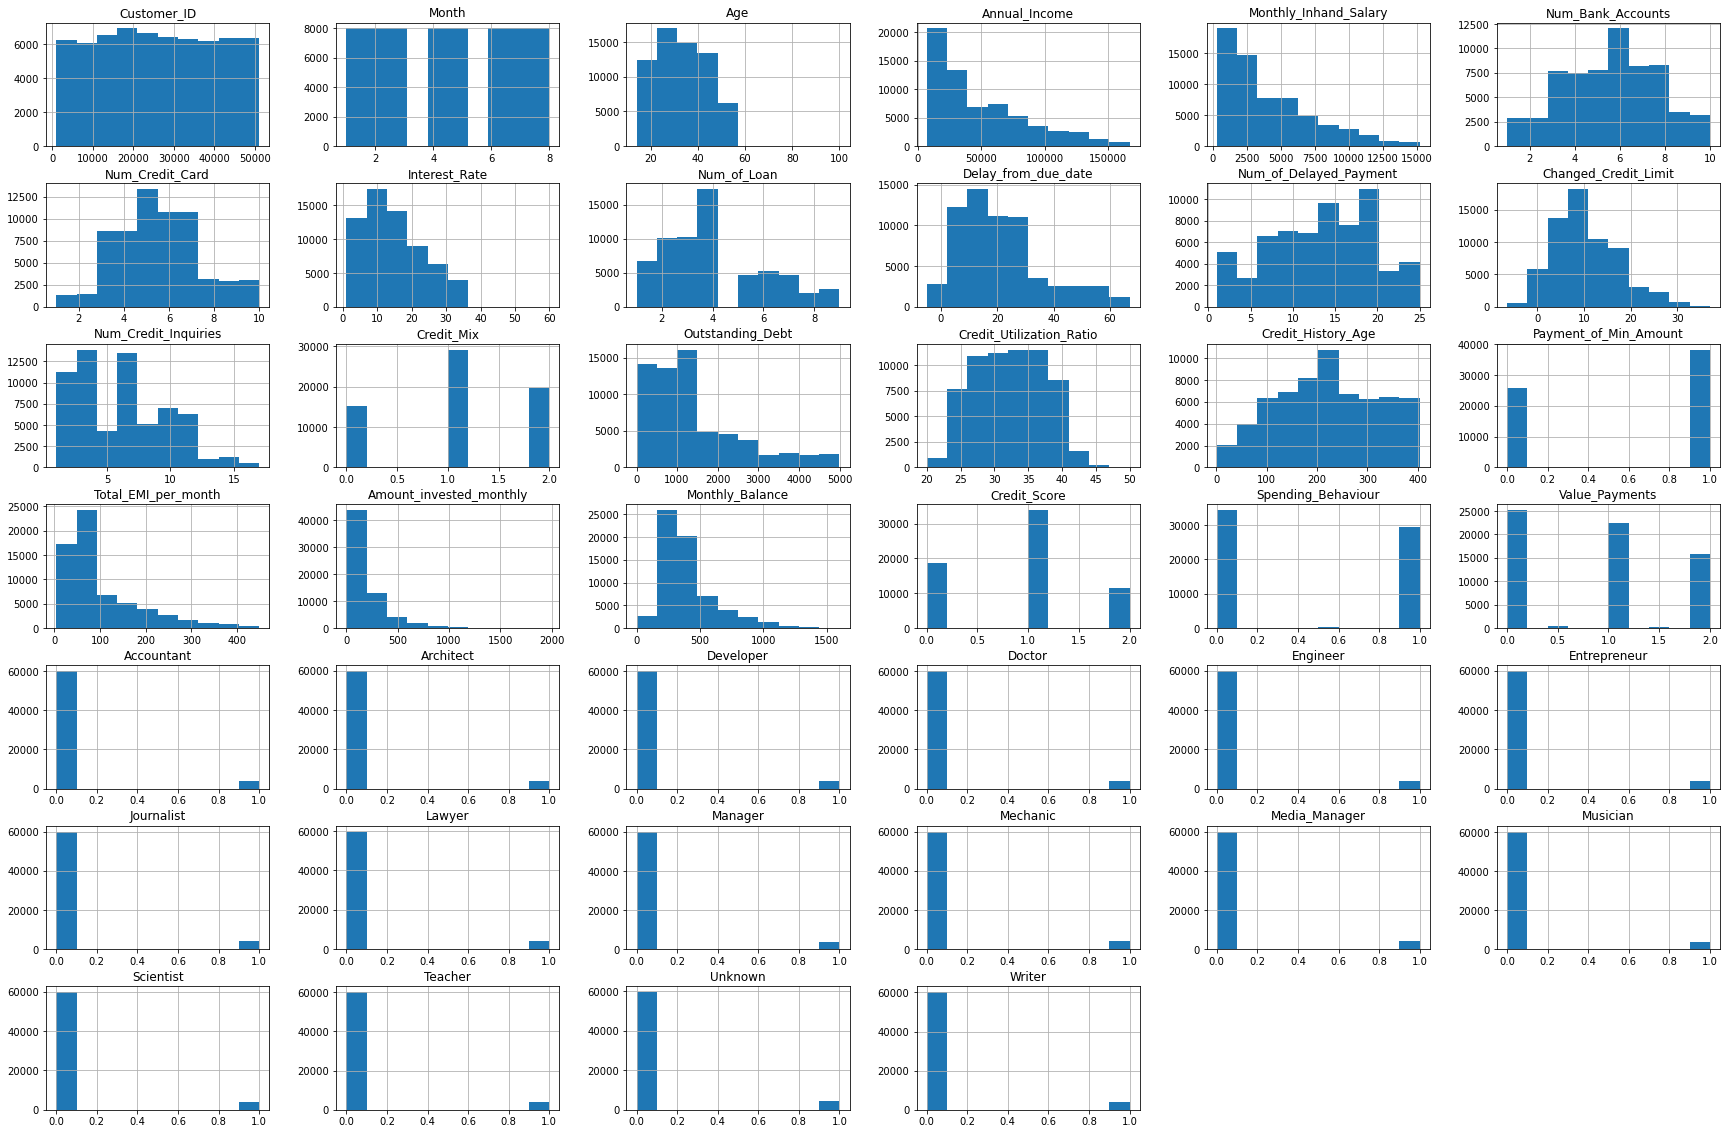

In [128]:
train.hist(figsize=(30, 20))

<AxesSubplot:>

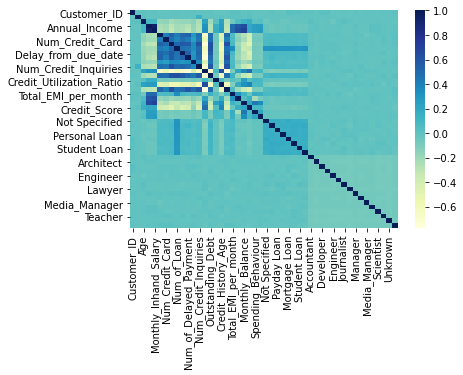

In [129]:
sns.heatmap(train.corr(), cmap="YlGnBu")

# Choice of columns

In [34]:
# first we'll take a look at correlated columns
# train_dropped = train_transformed.drop(columns = ["Monthly_Balance",
#                                                   "Amount_invested_monthly",
#                                                   "Annual_Income"])
    

# train_corr = train_dropped.corr()

# t = (abs(train_corr) > 0.5) + 0.

# strong_corelation_columns = ["Num_Bank_Accounts", "Num_Credit_Card", "Interest_Rate",
#                              "Num_of_Loan", "Delay_from_due_date", "Num_of_Delayed_Payment",
#                              "Changed_Credit_Limit", "Num_Credit_Inquiries", "Credit_Mix",
#                              "Outstanding_Debt", "Credit_History_Age", 
#                              "Payment_of_Min_Amount"]


# sns.heatmap(train_dropped[strong_corelation_columns].corr(), annot=True)



# Model

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

In [130]:
# training dataset
y = train['Credit_Score']
del train['Credit_Score']
y_train = y
X_train = train

In [131]:
# validation dataset
val = prepipe.transform(val)
X_val = val
y_val = val["Credit_Score"]
del X_val["Credit_Score"]

Columns containing id-like information preprocessed
Numeric data preprocessed. Columns with numeric values contain numeric only variables. Changed columns types
Deleted outliers
NA values imputed within text columns
Categorical columns with string values encoded. Added new columns where necessary (one-hot encoding)
NA values imputed within numeric columns


In [132]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64000 entries, 0 to 63999
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               64000 non-null  int64  
 1   Month                     64000 non-null  int64  
 2   Age                       64000 non-null  float64
 3   Annual_Income             64000 non-null  float64
 4   Monthly_Inhand_Salary     64000 non-null  float64
 5   Num_Bank_Accounts         64000 non-null  float64
 6   Num_Credit_Card           64000 non-null  float64
 7   Interest_Rate             64000 non-null  float64
 8   Num_of_Loan               64000 non-null  float64
 9   Delay_from_due_date       64000 non-null  int64  
 10  Num_of_Delayed_Payment    64000 non-null  float64
 11  Changed_Credit_Limit      64000 non-null  float64
 12  Num_Credit_Inquiries      64000 non-null  float64
 13  Credit_Mix                64000 non-null  float64
 14  Outsta

In [133]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16000 entries, 64000 to 79999
Data columns (total 47 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               16000 non-null  int64  
 1   Month                     16000 non-null  int64  
 2   Age                       16000 non-null  float64
 3   Annual_Income             16000 non-null  float64
 4   Monthly_Inhand_Salary     16000 non-null  float64
 5   Num_Bank_Accounts         16000 non-null  float64
 6   Num_Credit_Card           16000 non-null  float64
 7   Interest_Rate             16000 non-null  float64
 8   Num_of_Loan               16000 non-null  float64
 9   Delay_from_due_date       16000 non-null  int64  
 10  Num_of_Delayed_Payment    16000 non-null  float64
 11  Changed_Credit_Limit      16000 non-null  float64
 12  Num_Credit_Inquiries      16000 non-null  float64
 13  Credit_Mix                16000 non-null  float64
 14  Ou

# Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier

In [134]:
rf_model = RandomForestClassifier(n_estimators=120)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=120)

In [135]:
y_pred = rf_model.predict(X_val)

In [136]:
print(classification_report(y_pred, y_val))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69      4350
           1       0.73      0.75      0.74      8470
           2       0.64      0.52      0.58      3180

    accuracy                           0.69     16000
   macro avg       0.68      0.66      0.67     16000
weighted avg       0.69      0.69      0.69     16000



In [84]:
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   X_val.columns,
                                   columns=['Importance'])

In [76]:
feature_importances.sort_values(by='Importance', ascending=False).head(10)

,Importance
Outstanding_Debt,0.094237
Credit_Mix,0.072609
Interest_Rate,0.066473
Credit_History_Age,0.060918
Delay_from_due_date,0.053294
Changed_Credit_Limit,0.049671
Monthly_Balance,0.040955
Amount_invested_monthly,0.039487
Credit_Utilization_Ratio,0.037373
Num_Credit_Card,0.036814


# Dropping highly correlated columns

In [77]:
columns_to_delete = []
for i in range(len(X_train.columns)):
    for j in range(i+1, len(X_train.columns)):
        # we iterate over every pair of columns
        # if the correlation between them is over 0.5 we eliminate the less predictive (for our particular model) column
        if (abs(X_train[X_train.columns[i]].corr(X_train[X_train.columns[j]])) > 0.5):
            #print(feature_importances.loc[X_train.columns[i]].name, X_train[X_train.columns[i]].corr(X_train[X_train.columns[j]]), feature_importances.loc[X_train.columns[j]].name)
            p#rint(feature_importances.loc[X_train.columns[i]][0], feature_importances.loc[X_train.columns[j]][0])
            if feature_importances.loc[X_train.columns[i]][0] < feature_importances.loc[X_train.columns[j]][0]:
                columns_to_delete.append(feature_importances.loc[X_train.columns[i]].name)
            else:
                columns_to_delete.append(feature_importances.loc[X_train.columns[j]].name)

Annual_Income 0.9457129466976906 Monthly_Inhand_Salary
0.0340231361446552 0.03460175771511543
Annual_Income 0.5342843874409052 Total_EMI_per_month
0.0340231361446552 0.03173930015609334
Annual_Income 0.5996382980664244 Amount_invested_monthly
0.0340231361446552 0.039486872388413446
Annual_Income 0.6569666669610965 Monthly_Balance
0.0340231361446552 0.04095539711693493
Monthly_Inhand_Salary 0.5383897650394628 Total_EMI_per_month
0.03460175771511543 0.03173930015609334
Monthly_Inhand_Salary 0.6350345296467726 Amount_invested_monthly
0.03460175771511543 0.039486872388413446
Monthly_Inhand_Salary 0.7043603742347478 Monthly_Balance
0.03460175771511543 0.04095539711693493
Num_Bank_Accounts 0.5461339000888228 Interest_Rate
0.0261523568860077 0.06647339282875703
Num_Bank_Accounts 0.5335702566939295 Delay_from_due_date
0.0261523568860077 0.05329365237018584
Num_Bank_Accounts 0.5424779644712474 Num_of_Delayed_Payment
0.0261523568860077 0.03549595867833298
Num_Bank_Accounts -0.6679835197867847 Cr

In [78]:
columns_to_delete = list(set(columns_to_delete)) # get unique values
columns_to_delete

['Total_EMI_per_month',
 'Payment_of_Min_Amount',
 'Annual_Income',
 'Num_Bank_Accounts',
 'Monthly_Inhand_Salary',
 'Num_Credit_Card',
 'Credit_Mix',
 'Num_of_Loan',
 'Delay_from_due_date',
 'Interest_Rate',
 'Num_Credit_Inquiries',
 'Credit_History_Age',
 'Num_of_Delayed_Payment']

In [79]:
X_train_2 = X_train.drop(columns_to_delete, axis=1)
X_val_2 = X_val.drop(columns_to_delete, axis=1) 

In [82]:
feature_importances.columns

Index(['Importance'], dtype='object')

In [86]:
feature_importances_2 = feature_importances.loc[feature_importances.index.isin(X_train_2)].sort_values(by='Importance', ascending=False)
feature_importances_2

,Importance
Outstanding_Debt,0.094237
Changed_Credit_Limit,0.049671
Monthly_Balance,0.040955
Amount_invested_monthly,0.039487
Credit_Utilization_Ratio,0.037373
Month,0.034666
Customer_ID,0.033364
Age,0.031632
Value_Payments,0.012295
Spending_Behaviour,0.007724


# New model, trained without highly correlated columns

In [70]:
rf_model_2 = RandomForestClassifier(n_estimators=100)
rf_model_2.fit(X_train_2, y_train)

RandomForestClassifier()

In [71]:
y_pred_2 = rf_model_2.predict(X_val_2)

In [72]:
print(classification_report(y_pred_2, y_val))

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      4475
           1       0.73      0.74      0.73      8576
           2       0.60      0.53      0.56      2949

    accuracy                           0.69     16000
   macro avg       0.66      0.65      0.66     16000
weighted avg       0.68      0.69      0.68     16000



# XGBoost attempt

In [87]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import (
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


In [88]:
gbc_model= GradientBoostingClassifier()
gbc_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [52]:
y_pred_xgboost = gbc_model.predict(X_val)

In [53]:
print(classification_report(y_pred_xgboost, y_val))

              precision    recall  f1-score   support

           0       0.66      0.71      0.68      4389
           1       0.73      0.75      0.74      8452
           2       0.65      0.54      0.59      3159

    accuracy                           0.70     16000
   macro avg       0.68      0.67      0.67     16000
weighted avg       0.70      0.70      0.70     16000



In [137]:
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=10, n_jobs=-1)
randomForest = RandomForestClassifier(n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)

model = StackingClassifier([
    ('bagging', bagging),
    ('extraTress', extraTrees),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('XGB', XGB)
], n_jobs=-1)

In [138]:
model.fit(X_train, y_train)

StackingClassifier(estimators=[('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTress',
                                ExtraTreesClassifier(max_depth=10, n_jobs=-1)),
                               ('randomforest',
                                RandomForestClassifier(n_jobs=-1)),
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None...
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              n_estimators=100, n_jobs=-1,
                                              num_parallel_tree=None,
                                              predictor=None, random_state=None, ...))],
                   n_jobs=-1)

In [139]:
y_pred = model.predict(X_val)
print(classification_report(y_pred,y_val))

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      4276
           1       0.75      0.74      0.74      8788
           2       0.62      0.55      0.58      2936

    accuracy                           0.70     16000
   macro avg       0.67      0.67      0.67     16000
weighted avg       0.70      0.70      0.70     16000



In [54]:
# not in current use
import shap

def shapley(model, X_train, X_val):
    explainer = shap.Explainer(model, X_train)
    
    shap_values = explainer(X_train)
    shap.summary_plot(shap_values, X_train)
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])

    # freature importance    
    shap.summary_plot(shap_values, X_train, plot_type="bar")
    
    shap.plots.bar(shap_values)
    shap.summary_plot(shap_values, plot_type='violin')
    shap.plots.bar(shap_values[0])
    shap.plots.waterfall(shap_values[0])
    shap.plots.force(shap_values[0])
    
    
    shap.plots.force(shap_values[1])
    
    shap.plots.heatmap(shap_values)
    
    # fig = shap.force_plot(explainer.expected_value, shap_values.values, X_train, feature_names = X_train.columns)
    # fig.savefig('testplot.png')
    # fig.plot()
    
    # fig = shap.force_plot(shap_values, X_train)
    # fig.plot()
   
    shap_values = explainer(X_val)
    shap.plots.beeswarm(shap_values)
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values[0])
    
    # freature importance
    shap.summary_plot(shap_values, X_val, plot_type="bar")